In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [16]:
products = pd.read_csv("data_raw/instacart/products.csv")
orders = pd.read_csv("data_raw/instacart/orders.csv")
aisles = pd.read_csv("data_raw/instacart/aisles.csv")
departments = pd.read_csv("data_raw/instacart/departments.csv")
order_product = pd.read_csv("data_raw/instacart/order_products__prior.csv")[["order_id", "product_id"]]
order_nproducts = order_product.groupby("order_id", as_index=False).agg({"product_id":"count"}).rename(columns={"product_id":"different_products"})
orders_prior = orders[orders["order_id"].isin(order_nproducts["order_id"].unique())].merge(order_nproducts, how="left", left_on="order_id", right_on="order_id")
orders_prior["lunes"] = (orders_prior["order_dow"] == 0).astype(int)
orders_prior["martes"] = (orders_prior["order_dow"] == 1).astype(int)
orders_prior["miercoles"] = (orders_prior["order_dow"] == 2).astype(int)
orders_prior["jueves"] = (orders_prior["order_dow"] == 3).astype(int)
orders_prior["viernes"] = (orders_prior["order_dow"] == 4).astype(int)
orders_prior["sabado"] = (orders_prior["order_dow"] == 5).astype(int)
orders_prior["domingo"] = (orders_prior["order_dow"] == 6).astype(int)
orders_prior["am"] = (orders_prior["order_hour_of_day"] <12).astype(int)
orders_prior["pm"] = (orders_prior["order_hour_of_day"] >= 12).astype(int)

In [17]:
print("Cantidad de boletas: " + str(len(order_product)))
print("Cantidad de productos: " + str(len(products["product_id"])))

Cantidad de boletas: 32434489
Cantidad de productos: 49688


In [18]:
random.seed(12345)
print("Cantidad de clientes originales: ", str(len(orders_prior["user_id"].unique())))
users_sample = random.sample(orders_prior["user_id"].unique().tolist(), 10)
order_sample = orders_prior[orders_prior["user_id"].isin(users_sample)]["order_id"].unique()
op_sample = order_product[(order_product["order_id"].isin(order_sample))].copy()

print("Cantidad de productos en la muestra: " + str(len(op_sample.product_id.unique())))
print("Cantidad de boletas en la muestra: " + str(len(order_sample)))
op_count = op_sample.groupby(["order_id"], as_index=False).agg({"product_id":"count"}).rename(columns={"product_id":"product_count"})
print("Cantidad de productos comprados: " + str(op_count["product_count"].sum()))

products_sample = products[products["product_id"].isin(op_sample["product_id"].unique())].copy()
orders_sample = orders_prior[orders_prior["order_id"].isin(order_sample)].copy()

# Reiniciamos los id de los samples
products_sample["product_id_old"] = products_sample["product_id"]
products_sample = products_sample.reset_index(drop=True)
products_sample["product_id"] = range(1, len(products_sample) + 1)

orders_sample["order_id_old"] = orders_sample["order_id"]
orders_sample = orders_sample.reset_index(drop=True)
orders_sample["order_id"] = range(1, len(orders_sample) + 1)

user_map = {users_sample[i]:i+1 for i in range(len(users_sample))}
orders_sample["user_id"] = orders_sample["user_id"].map(user_map)

op_sample["order_id_old"] = op_sample["order_id"]
op_sample["product_id_old"] = op_sample["product_id"]

op_sample.drop(columns=["order_id", "product_id"], inplace=True)

op_sample = op_sample.merge(how="left", right=orders_sample[["order_id", "order_id_old"]], on="order_id_old")
op_sample = op_sample.merge(how="left", right=products_sample[["product_id", "product_id_old"]], on="product_id_old")
op_sample.drop(columns=["order_id_old", "product_id_old"], inplace=True)

Cantidad de clientes originales:  206209
Cantidad de productos en la muestra: 573
Cantidad de boletas en la muestra: 169
Cantidad de productos comprados: 1335


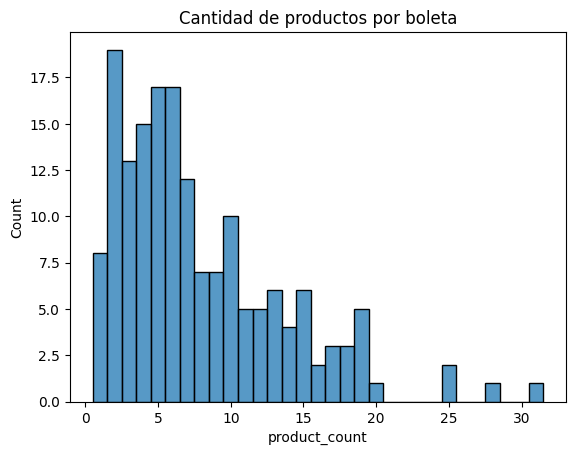

In [19]:
sns.histplot(op_count["product_count"], discrete=True)
plt.title("Cantidad de productos por boleta")
plt.show()

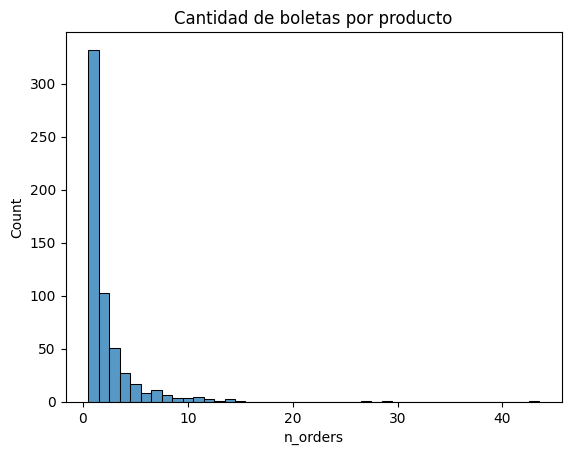

In [20]:
product_baskets = op_sample.groupby(["product_id"], as_index=False).agg({"order_id":"count"}).rename(columns={"order_id":"n_orders"})
product_baskets["relative_orders"] = product_baskets["n_orders"]/len(op_sample.order_id.unique())
product_baskets = product_baskets.merge(right=products, left_on="product_id", right_on="product_id", how="left")
sns.histplot(product_baskets[product_baskets["n_orders"]<=50]["n_orders"], discrete=True)
plt.title("Cantidad de boletas por producto")
plt.show()

<Axes: xlabel='order_count', ylabel='Count'>

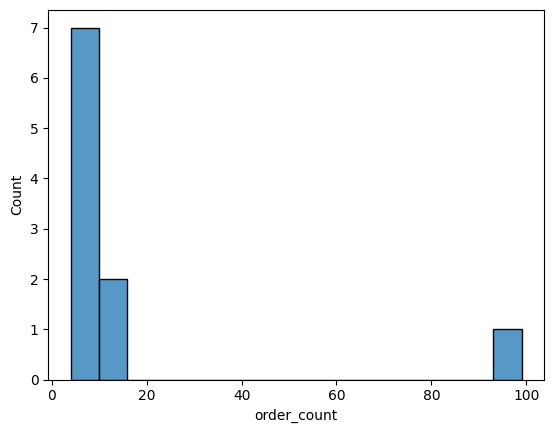

In [21]:
users_sample = orders_sample.groupby("user_id", as_index=False).agg({"order_id":"count","am":"mean", "pm":"mean", "lunes":"mean", "miercoles":"mean", "viernes":"mean", "domingo":"mean"}).rename(columns={"order_id":"order_count"})
sns.histplot(users_sample[users_sample["order_count"]>1]["order_count"])

In [22]:
orders_sample.to_csv("data/instacart/orders_sample.csv", index=False)
products_sample.to_csv("data/instacart/products_sample.csv", index=False)
op_sample.to_csv("data/instacart/order_product_sample.csv", index=False)

In [23]:
products_sample.head()

,product_id,product_name,aisle_id,department_id,product_id_old
0,1,Classics Earl Grey Tea,94,7,87
1,2,100% Recycled Aluminum Foil,97,13,160
2,3,Dried Sweetened Cranberries,117,19,248
3,4,Garnet Sweet Potato (Yam),83,4,581
4,5,Natural Liquid Laundry Detergent - Blue Eucaly...,75,17,605


In [24]:
orders_sample.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,different_products,lunes,martes,miercoles,jueves,viernes,sabado,domingo,am,pm,order_id_old
0,1,3,prior,1,0,14,NaN,7,1,0,0,0,0,0,0,0,1,817879
1,2,3,prior,2,0,13,14.0,5,1,0,0,0,0,0,0,0,1,1912776
2,3,3,prior,3,2,13,9.0,3,0,0,1,0,0,0,0,0,1,2619131
3,4,3,prior,4,1,18,6.0,2,0,1,0,0,0,0,0,0,1,3187743
4,5,10,prior,1,4,18,NaN,20,0,0,0,0,1,0,0,0,1,33578


In [25]:
op_sample.head()

,order_id,product_id
0,58,300
1,58,8
2,103,532
3,103,45
4,5,545


In [26]:
pc_sample = op_sample.groupby("product_id", as_index=False).agg({"order_id":"count"}).rename(columns={"order_id":"n_orders"})
pc_sample[pc_sample["n_orders"]==0].product_id.count()

np.int64(0)

In [27]:
op_sample

,order_id,product_id
0,58,300
1,58,8
2,103,532
3,103,45
4,5,545
...,...,...
1330,108,373
1331,108,558
1332,108,394
1333,108,264
